In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
import seaborn as sns

In [2]:
def simulator(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)

    # Replace the parameter value from ini file
    #pdb.set_trace()
    try:
        if theta.dim() > 1:
#             pdb.set_trace()
            print(theta.numel())
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[0][4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[0][6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())
            
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[0][6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[0][7].item())
            
        else:
            #pdb.set_trace()
            config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
            config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
            
            config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
            config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
            config['ArticStateEstimator']['process_scale'] = str(theta[4].item())
            config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

            config['SensoryDelay']['Auditory_delay'] = str(theta[6].item())
            config['SensoryDelay']['Somato_delay'] = str(theta[7].item())
            
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[7].item())
    except:
        pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    x_tilde_delaywindow = np.full([20,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([20,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+20,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+20,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+20,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+20,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+20,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+20,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+20,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
            
        
        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)
        
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return formants_produced_record_alltrials[:,:,0].squeeze() 


### Run an example trial, or do a parameter sweep

#### Auditory noise scale:

Low: 0.0001

High: 0.04


#### Somatosensory noise scale:

Low: .002

High: 1


#### TSE Process Scale:

Low: 0.0001

High: 5


#### TSE Covariance Scale:

Low: 0.0000001

High: 5

#### ASE Process Scale:

Low: 10e-12

High: 10e-6


#### ASE Covariance Scale:

Low: 10e-12

High: 10e-4


#### SensoryDelay Auditory Delay:

Low: 20

High: 105

#### SensoryDelay Somato Delay:

Low: 45

High: 105

#### TSE estimated_auditory_delay:

Low: 10 

High: 105

#### ASE estimated_somat_delay

Low: 10 

High: 30


param_value [0.009, 0.5, 1, 1, 1e-06, 1e-06, 100, 50]
8
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]


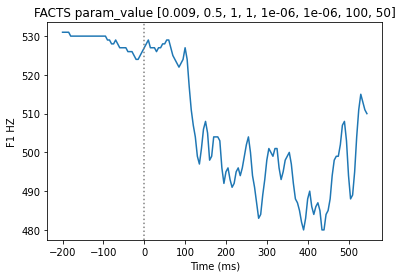

In [3]:
# Do the grid search
examples = []
# mu1 = 0.005
# param_values = [ [0.009, 0.5, 1, 1, 10e-7, 10e-7, 75, int(x)] for x in  np.linspace(75, 100, num=1)]
param_values = [ [0.009, 0.5, 1, 1, 10e-7, 10e-7, 100, 50] for x in  np.linspace(75, 100, num=1)]

plot = True

# Create coarse grid
# Sens_Noise_Aud_Sense_scale = np.linspace(0.0001, 0.04, num=3)
# Sens_Noise_Somato_Sense_scale = np.linspace(0.002, 1, num=3)
# TSE_process_scale = np.linspace( 0.0001, 5, num=3)
# TSE_covar_scale = np.linspace(0.0000001, 5, num=3)
# ASE_process_scale = np.linspace(10e-12, 10e-6, num=3)
# ASE_covar_scale = np.linspace(10e-12, 10e-4, num=3)

# Grid = [Sens_Noise_Aud_Sense_scale, Sens_Noise_Somato_Sense_scale TSE_process_scale, ...
#        TSE_covar_scale, ASE_process_scale, ASE_covar_scale]
            

for ii in param_values:
    print(f"param_value {ii}")
    example = simulator(torch.tensor([ii]))
    examples.append(example)
    
    if plot == True:
        plt.figure()
        plt.title(f'FACTS param_value {ii}')
        example_x = (np.arange(len(example))*5)-200
        plt.plot(example_x,example)
        plt.axvline(x = 0, color = 'grey', ls=':')
        plt.xlabel('Time (ms)')
        plt.ylabel('F1 HZ')
        plt.show()
        


### Load Kyunghee's data and compare to FACTS

(1, 194)
(1797, 194)
(1, 150)
(1797, 150)


Text(0, 0.5, 'F1 HZ')

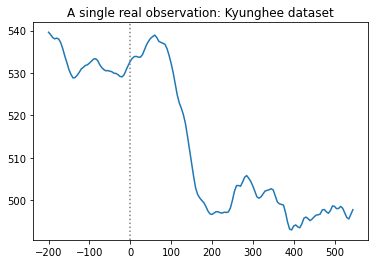

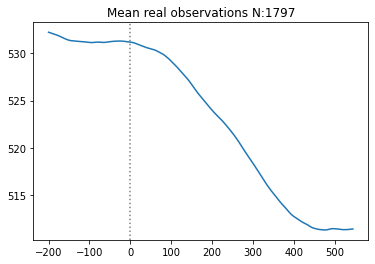

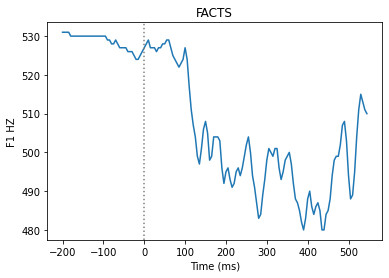

In [4]:
# Import real observed data
import scipy.io
example = examples[0]

trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time

print(trial_cells_times.shape)
print(trial_cells_mat.shape)
trial_cells_times = trial_cells_times[:,0:150]
trial_cells_mat = trial_cells_mat[:,0:150]
print(trial_cells_times.shape)
print(trial_cells_mat.shape)

# # Alter the trial_cells so that they center to where FACTS centers
trial_cells_mat = trial_cells_mat + 531

# Plot and compare observed data to FACTS data
plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title('A single real observation: Kyunghee dataset')
# plt.ylim([510,535])

plt.figure()
plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
plt.axvline(x = 0, color = 'grey', ls=':')
plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')
# plt.ylim([510,535])

# # Now realign so that 
plt.figure()
plt.title('FACTS')
example_x = (np.arange(len(example))*5)-200
plt.plot(example_x,example)
plt.axvline(x = 0, color = 'grey', ls=':')
plt.xlabel('Time (ms)')
plt.ylabel('F1 HZ')
# plt.ylim([510,535])

In [5]:
print(np.min(trial_cells_mat[729,:]))
print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

493.03972341681293
511.3030736359036


In [5]:
from sbi.inference import infer, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import pickle
# import facts_for_SBI

load_instead = False

#Auditory noise scale:
# Low: 0.0001
# High: 0.04
#Somatosensory noise scale:
# Low: .002
# High: 1
#TSE Process Scale:
# Low: 0.0001
# High: 5
#TSE Covariance Scale:
# Low: 0.0000001
# High: 5
#ASE Process Scale:
# Low: 10e-12
# High: 10e-6
#ASE Covariance Scale:
# Low: 10e-12
# High: 10e-4
#SensoryDelay Auditory Delay:
# Low: 20
# High: 105
#SensoryDelay Somato Delay:
# Low: 45
# High: 105

# import your simulator, define your prior over the parameters
#prior_mean = 0.002
prior_min= [0.0001, 0.002, 0.0001, 0.0000001, 10e-12, 10e-12, 20, 20]
prior_mmax = [0.04, 1.0, 5, 5, 10e-6, 10e-4, 105, 105] 
num_sim = 1000
num_workers = 6

# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
if load_instead == False:
    prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
    simulator, prior = prepare_for_sbi(simulator, prior)
    inference = SNPE(prior)
    
    theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
    #parameter_posterior = infer(simulator, prior, method='SNPE', num_simulations=num_sim, num_workers=num_workers)
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator)
    
    # Save the theta and x
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([theta, x], f)
    # Save the posterior
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([posterior], f)
    
else:
    file = open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}.pkl', 'rb')
    object_file = pickle.load(file)
    posterior = object_file[0]
    file.close()

16
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.

 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.

 Neural network successfully converged after 94 epochs.

## Try flexible interface where you load pickle and simulate on top of it

In [8]:
# Load pickle data
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    object_file = pickle.load(f)
    theta2, x2 = object_file
        
    # Run more simulations
    theta3, x3 = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000, num_workers=num_workers)
    
    # Append 
    theta4 = torch.cat((theta2, theta3))
    x4 = torch.cat((x2, x3))
    
    density_estimator = inference.append_simulations(theta4, x4).train(force_first_round_loss=True) # Look more into force_first_round_loss=True
    posterior2 = inference.build_posterior(density_estimator)
    
#   file.close()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ][-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.0

 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.

 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.

 Neural network successfully converged after 138 epochs.

## Sample the posterior for a single point from Kyunghee's observations

In [ ]:
# object_file = pickle.load(file)
# parameter_posterior = object_file[0]
# file.close()
    
# print(single_trial.shape)
# print()

In [6]:
# import pandas as pd
# pd.options.display.max_rows = 4000

mean_trials = np.mean(trial_cells_mat, 0)
single_trial = trial_cells_mat[729]

# samples = posterior.sample((10,), x=single_trial)
# log_probability = posterior.log_prob(samples, x=single_trial)
# # out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')
# test = samples.numpy()
# # print(test[0])
# n, bins, patches = plt.hist(test, density=True, bins=30)
# plt.ylabel('Density')
# plt.xlabel('Auditory noise scale')

## Sample the posterior for the mean of all trials

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

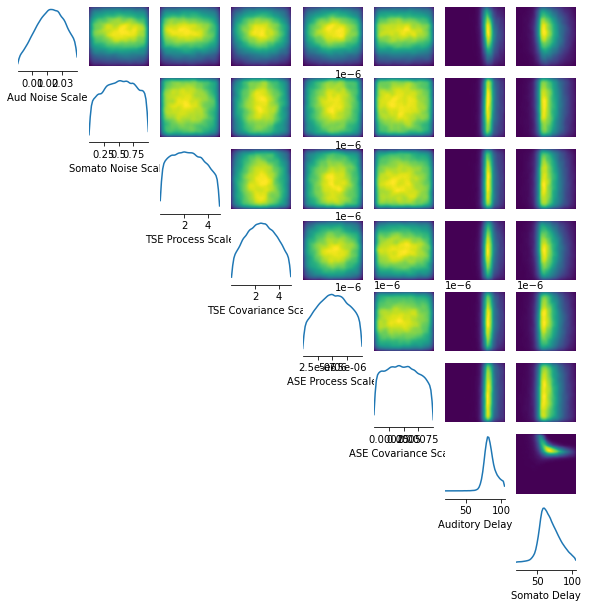

In [7]:
from sbi.analysis import pairplot
labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
          'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale', 'Auditory Delay', 'Somato Delay']

samples = posterior.sample((1000000,), x=mean_trials)
log_probability = posterior.log_prob(samples, x=mean_trials)
out = pairplot(samples, fig_size=(10,10), upper='kde', diag='kde', labels=labels)

## Now compare to the second posterior

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]


[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)



[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)



[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)



[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0.177  -0.2135 -0.08    0.09   -1.108   0.5655  1.281
 -0.8345 -0.08    0.084 ]
[-0.3725  0.2215  0

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


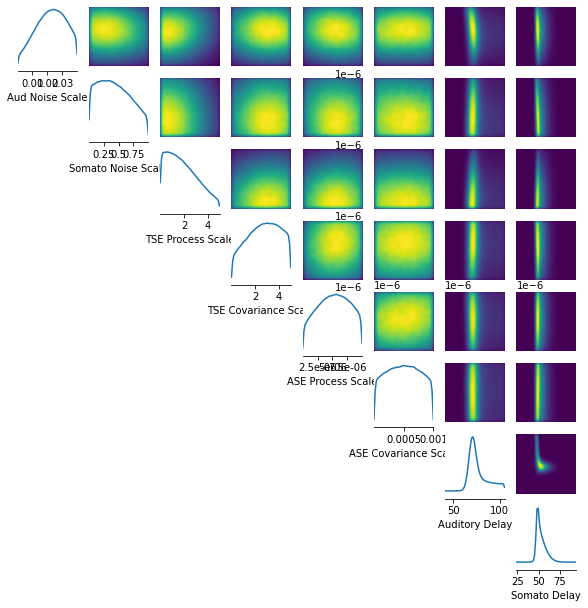

In [9]:
samples = posterior2.sample((1000000,), x=mean_trials)
log_probability = posterior2.log_prob(samples, x=mean_trials)
out = pairplot(samples, fig_size=(10,10), upper='kde', diag='kde', labels=labels)

# Plot for a single trial

In [ ]:
single_trial = trial_cells_mat[729]

samples = posterior2.sample((10000,), x=single_trial)
log_probability = posterior2.log_prob(samples, x=single_trial)
out = pairplot(samples, fig_size=(10,10), upper='kde', diag='kde', labels=labels)
# out = utils.pairplot(samples, fig_size=(10,6), upper='kde', diag='kde')

In [ ]:
# prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )

# samplesk = []
# n_samples = 10000
# for kk in range(n_samples):
#     samplesk.append(prior.sample())
    
# print(prior)
# plt.hist(samplesk)
# plt.xlabel('Parameter Value')
# plt.ylabel('Frequency')
# plt.title(f'{n_samples} samples drawn from Box Uniform prior\n low: 1.0000e-04; high: 0.0400')

# Find the argmax of these distributions and compare the model output to empirial output 